# PROVIDE FILENAMES

In [ ]:
MODEL_FILE = 'model_ep4_samples100_batch20.h5'
TOKENIZER_FILE = 'tokenizer_samples100_batch20.p'
SAMPLES_PICKLE_FILE = 'pickles/sampled_100_midi.pkl'
NOTE_TOKENIZER_PICKLE_FILE = 'pickles/note_tokenizer_100_samples.pkl'

# Environment setup

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir('/content/drive/Shareddrives/295/Code/RNN_Transformer')

In [ ]:
!pip install -r requirements.txt

     |████████████████████████████████| 5.6 MB 29.2 MB/s 
ERROR: Could not find a version that satisfies the requirement tensorflow==2.2.0rc4 (from versions: 1.13.1, 1.13.2, 1.14.0, 1.15.0, 1.15.2, 1.15.3, 1.15.4, 1.15.5, 2.0.0, 2.0.1, 2.0.2, 2.0.3, 2.0.4, 2.1.0, 2.1.1, 2.1.2, 2.1.3, 2.1.4, 2.2.0, 2.2.1, 2.2.2, 2.2.3, 2.3.0, 2.3.1, 2.3.2, 2.3.3, 2.3.4, 2.4.0, 2.4.1, 2.4.2, 2.4.3, 2.4.4, 2.5.0, 2.5.1, 2.5.2, 2.5.3, 2.6.0rc0, 2.6.0rc1, 2.6.0rc2, 2.6.0, 2.6.1, 2.6.2, 2.6.3, 2.7.0rc0, 2.7.0rc1, 2.7.0, 2.7.1, 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.9.0rc0, 2.9.0rc1)
ERROR: No matching distribution found for tensorflow==2.2.0rc4


In [ ]:
import tensorflow as tf
from tensorflow.keras import backend as K
import glob
import random
import pretty_midi
import IPython
import numpy as np
from tqdm.notebook import tnrange, tqdm_notebook, tqdm
from random import shuffle, seed
import numpy as np
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.optimizers import Nadam
import numpy as np
from numpy.random import choice
import pickle
import matplotlib.pyplot as plt

import unicodedata
import re
import numpy as np
import os
import io
import time
import pickle

In [ ]:
!pwd

/content/drive/Shareddrives/295/Code/RNN_Transformer


# Run the preprocess_midi and get the training samples and the note tokenizer

In [ ]:
%run preprocess_midi.ipynb import NoteTokenizer

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/Shareddrives/295/Code/RNN_Transformer


  0%|          | 0/100 [00:00<?, ?it/s]

maestro-v1.0.0/2006/MIDI-Unprocessed_10_R1_2006_01-04_ORIG_MID--AUDIO_10_R1_2006_03_Track03_wav.midi
Instrument(program=0, is_drum=False, name="")
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]] (128, 6315)
maestro-v1.0.0/2008/MIDI-Unprocessed_07_R1_2008_01-04_ORIG_MID--AUDIO_07_R1_2008_wav--3.midi
Instrument(program=0, is_drum=False, name="")
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]] (128, 1285)
maestro-v1.0.0/2017/MIDI-Unprocessed_047_PIANO047_MID--AUDIO-split_07-06-17_Piano-e_2-04_wav--4.midi
Instrument(program=0, is_drum=False, name="")
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]] (128, 2520)
maestro-v1.0.0/2011/MIDI-Unprocessed_08_R1_2011_MID--AUDIO_R1-D

In [ ]:
sampled_200_midi_pkl = open(SAMPLES_PICKLE_FILE, 'rb')
sampled_200_midi = pickle.load(sampled_200_midi_pkl)
sampled_200_midi_pkl.close()

In [ ]:
note_tokenizer_pkl = open(NOTE_TOKENIZER_PICKLE_FILE, 'rb')
note_tokenizer = pickle.load(note_tokenizer_pkl)
note_tokenizer_pkl.close()

In [ ]:
def piano_roll_to_pretty_midi(piano_roll, fs=100, program=0):
    '''Convert a Piano Roll array into a PrettyMidi object
     with a single instrument.
    Parameters
    ----------
    piano_roll : np.ndarray, shape=(128,frames), dtype=int
        Piano roll of one instrument
    fs : int
        Sampling frequency of the columns, i.e. each column is spaced apart
        by ``1./fs`` seconds.
    program : int
        The program number of the instrument.
    Returns
    -------
    midi_object : pretty_midi.PrettyMIDI
        A pretty_midi.PrettyMIDI class instance describing
        the piano roll.
    '''
    notes, frames = piano_roll.shape
    pm = pretty_midi.PrettyMIDI()
    instrument = pretty_midi.Instrument(program=program)

    # pad 1 column of zeros so we can acknowledge inital and ending events
    piano_roll = np.pad(piano_roll, [(0, 0), (1, 1)], 'constant')

    # use changes in velocities to find note on / note off events
    velocity_changes = np.nonzero(np.diff(piano_roll).T)

    # keep track on velocities and note on times
    prev_velocities = np.zeros(notes, dtype=int)
    note_on_time = np.zeros(notes)

    for time, note in zip(*velocity_changes):
        # use time + 1 because of padding above
        velocity = piano_roll[note, time + 1]
        time = time / fs
        if velocity > 0:
            if prev_velocities[note] == 0:
                note_on_time[note] = time
                prev_velocities[note] = velocity
        else:
            pm_note = pretty_midi.Note(
                velocity=prev_velocities[note],
                pitch=note,
                start=note_on_time[note],
                end=time)
            instrument.notes.append(pm_note)
            prev_velocities[note] = 0
    pm.instruments.append(instrument)
    return pm


# Make Architecture
Now we will make the architecture.. 
We will try to make the architecture as follow:
1. Embedding
2. LSTM
3. Self Head Attention
4. LSTM
5. Self Head Attention
6. Dense

In [ ]:
seq_len = 50
EPOCHS = 4
BATCH_SONG = 16
BATCH_NNET_SIZE = 96
TOTAL_SONGS = len(sampled_200_midi)
FRAME_PER_SECOND = 5


We will use the code from here for self-attention  
https://github.com/CyberZHG/keras-self-attention/blob/master/keras_self_attention/seq_self_attention.py

In [ ]:
class SeqSelfAttention(tf.keras.layers.Layer):

    ATTENTION_TYPE_ADD = 'additive'
    ATTENTION_TYPE_MUL = 'multiplicative'

    def __init__(self,
                 units=32,
                 attention_width=None,
                 attention_type=ATTENTION_TYPE_ADD,
                 return_attention=False,
                 history_only=False,
                 kernel_initializer='glorot_normal',
                 bias_initializer='zeros',
                 kernel_regularizer=None,
                 bias_regularizer=None,
                 kernel_constraint=None,
                 bias_constraint=None,
                 use_additive_bias=True,
                 use_attention_bias=True,
                 attention_activation=None,
                 attention_regularizer_weight=0.0,
                 **kwargs):
        """Layer initialization.
        For additive attention, see: https://arxiv.org/pdf/1806.01264.pdf
        :param units: The dimension of the vectors that used to calculate the attention weights.
        :param attention_width: The width of local attention.
        :param attention_type: 'additive' or 'multiplicative'.
        :param return_attention: Whether to return the attention weights for visualization.
        :param history_only: Only use historical pieces of data.
        :param kernel_initializer: The initializer for weight matrices.
        :param bias_initializer: The initializer for biases.
        :param kernel_regularizer: The regularization for weight matrices.
        :param bias_regularizer: The regularization for biases.
        :param kernel_constraint: The constraint for weight matrices.
        :param bias_constraint: The constraint for biases.
        :param use_additive_bias: Whether to use bias while calculating the relevance of inputs features
                                  in additive mode.
        :param use_attention_bias: Whether to use bias while calculating the weights of attention.
        :param attention_activation: The activation used for calculating the weights of attention.
        :param attention_regularizer_weight: The weights of attention regularizer.
        :param kwargs: Parameters for parent class.
        """
        self.supports_masking = True
        self.units = units
        self.attention_width = attention_width
        self.attention_type = attention_type
        self.return_attention = return_attention
        self.history_only = history_only
        if history_only and attention_width is None:
            self.attention_width = int(1e9)

        self.use_additive_bias = use_additive_bias
        self.use_attention_bias = use_attention_bias
        self.kernel_initializer = tf.keras.initializers.get(kernel_initializer)
        self.bias_initializer = tf.keras.initializers.get(bias_initializer)
        self.kernel_regularizer = tf.keras.regularizers.get(kernel_regularizer)
        self.bias_regularizer = tf.keras.regularizers.get(bias_regularizer)
        self.kernel_constraint = tf.keras.constraints.get(kernel_constraint)
        self.bias_constraint = tf.keras.constraints.get(bias_constraint)
        self.attention_activation = tf.keras.activations.get(attention_activation)
        self.attention_regularizer_weight = attention_regularizer_weight
        self._backend = tf.keras.backend.backend()

        if attention_type == SeqSelfAttention.ATTENTION_TYPE_ADD:
            self.Wx, self.Wt, self.bh = None, None, None
            self.Wa, self.ba = None, None
        elif attention_type == SeqSelfAttention.ATTENTION_TYPE_MUL:
            self.Wa, self.ba = None, None
        else:
            raise NotImplementedError('No implementation for attention type : ' + attention_type)

        super(SeqSelfAttention, self).__init__(**kwargs)

    def get_config(self):
        config = {
            'units': self.units,
            'attention_width': self.attention_width,
            'attention_type': self.attention_type,
            'return_attention': self.return_attention,
            'history_only': self.history_only,
            'use_additive_bias': self.use_additive_bias,
            'use_attention_bias': self.use_attention_bias,
            'kernel_initializer': tf.keras.regularizers.serialize(self.kernel_initializer),
            'bias_initializer': tf.keras.regularizers.serialize(self.bias_initializer),
            'kernel_regularizer': tf.keras.regularizers.serialize(self.kernel_regularizer),
            'bias_regularizer': tf.keras.regularizers.serialize(self.bias_regularizer),
            'kernel_constraint': tf.keras.constraints.serialize(self.kernel_constraint),
            'bias_constraint': tf.keras.constraints.serialize(self.bias_constraint),
            'attention_activation': tf.keras.activations.serialize(self.attention_activation),
            'attention_regularizer_weight': self.attention_regularizer_weight,
        }
        base_config = super(SeqSelfAttention, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def build(self, input_shape):
        if isinstance(input_shape, list):
            input_shape = input_shape[0]
        if self.attention_type == SeqSelfAttention.ATTENTION_TYPE_ADD:
            self._build_additive_attention(input_shape)
        elif self.attention_type == SeqSelfAttention.ATTENTION_TYPE_MUL:
            self._build_multiplicative_attention(input_shape)
        super(SeqSelfAttention, self).build(input_shape)

    def _build_additive_attention(self, input_shape):
        feature_dim = input_shape[2]

        self.Wt = self.add_weight(shape=(feature_dim, self.units),
                                  name='{}_Add_Wt'.format(self.name),
                                  initializer=self.kernel_initializer,
                                  regularizer=self.kernel_regularizer,
                                  constraint=self.kernel_constraint)
        self.Wx = self.add_weight(shape=(feature_dim, self.units),
                                  name='{}_Add_Wx'.format(self.name),
                                  initializer=self.kernel_initializer,
                                  regularizer=self.kernel_regularizer,
                                  constraint=self.kernel_constraint)
        if self.use_additive_bias:
            self.bh = self.add_weight(shape=(self.units,),
                                      name='{}_Add_bh'.format(self.name),
                                      initializer=self.bias_initializer,
                                      regularizer=self.bias_regularizer,
                                      constraint=self.bias_constraint)

        self.Wa = self.add_weight(shape=(self.units, 1),
                                  name='{}_Add_Wa'.format(self.name),
                                  initializer=self.kernel_initializer,
                                  regularizer=self.kernel_regularizer,
                                  constraint=self.kernel_constraint)
        if self.use_attention_bias:
            self.ba = self.add_weight(shape=(1,),
                                      name='{}_Add_ba'.format(self.name),
                                      initializer=self.bias_initializer,
                                      regularizer=self.bias_regularizer,
                                      constraint=self.bias_constraint)

    def _build_multiplicative_attention(self, input_shape):
        feature_dim = input_shape[2]

        self.Wa = self.add_weight(shape=(feature_dim, feature_dim),
                                  name='{}_Mul_Wa'.format(self.name),
                                  initializer=self.kernel_initializer,
                                  regularizer=self.kernel_regularizer,
                                  constraint=self.kernel_constraint)
        if self.use_attention_bias:
            self.ba = self.add_weight(shape=(1,),
                                      name='{}_Mul_ba'.format(self.name),
                                      initializer=self.bias_initializer,
                                      regularizer=self.bias_regularizer,
                                      constraint=self.bias_constraint)

    def call(self, inputs, mask=None, **kwargs):
        if isinstance(inputs, list):
            inputs, positions = inputs
            positions = K.cast(positions, 'int32')
            mask = mask[1]
        else:
            positions = None

        input_len = K.shape(inputs)[1]

        if self.attention_type == SeqSelfAttention.ATTENTION_TYPE_ADD:
            e = self._call_additive_emission(inputs)
        elif self.attention_type == SeqSelfAttention.ATTENTION_TYPE_MUL:
            e = self._call_multiplicative_emission(inputs)

        if self.attention_activation is not None:
            e = self.attention_activation(e)
        e = K.exp(e - K.max(e, axis=-1, keepdims=True))
        if self.attention_width is not None:
            ones = tf.ones((input_len, input_len))
            if self.history_only:
                local = tf.linalg.band_part(
                    ones,
                    K.minimum(input_len, self.attention_width - 1),
                    0,
                )
            else:
                local = tf.linalg.band_part(
                    ones,
                    K.minimum(input_len, self.attention_width // 2),
                    K.minimum(input_len, (self.attention_width - 1) // 2),
                )
            e = e * K.expand_dims(local, 0)
        if mask is not None:
            mask = K.cast(mask, K.floatx())
            mask = K.expand_dims(mask)
            e = K.permute_dimensions(K.permute_dimensions(e * mask, (0, 2, 1)) * mask, (0, 2, 1))

        # a_{t} = \text{softmax}(e_t)
        s = K.sum(e, axis=-1)
        s = K.tile(K.expand_dims(s, axis=-1), K.stack([1, 1, input_len]))
        a = e / (s + K.epsilon())

        # l_t = \sum_{t'} a_{t, t'} x_{t'}
        v = K.batch_dot(a, inputs)
        if self.attention_regularizer_weight > 0.0:
            self.add_loss(self._attention_regularizer(a))

        if positions is not None:
            pos_num = K.shape(positions)[1]
            batch_indices = K.tile(K.expand_dims(K.arange(K.shape(inputs)[0]), axis=-1), K.stack([1, pos_num]))
            pos_indices = K.stack([batch_indices, positions], axis=-1)
            v = tf.gather_nd(v, pos_indices)
            a = tf.gather_nd(a, pos_indices)

        if self.return_attention:
            return [v, a]
        return v

    def _call_additive_emission(self, inputs):
        input_shape = K.shape(inputs)
        batch_size, input_len = input_shape[0], input_shape[1]

        # h_{t, t'} = \tanh(x_t^T W_t + x_{t'}^T W_x + b_h)
        q, k = K.dot(inputs, self.Wt), K.dot(inputs, self.Wx)
        q = K.tile(K.expand_dims(q, 2), K.stack([1, 1, input_len, 1]))
        k = K.tile(K.expand_dims(k, 1), K.stack([1, input_len, 1, 1]))
        if self.use_additive_bias:
            h = K.tanh(q + k + self.bh)
        else:
            h = K.tanh(q + k)

        # e_{t, t'} = W_a h_{t, t'} + b_a
        if self.use_attention_bias:
            e = K.reshape(K.dot(h, self.Wa) + self.ba, (batch_size, input_len, input_len))
        else:
            e = K.reshape(K.dot(h, self.Wa), (batch_size, input_len, input_len))
        return e

    def _call_multiplicative_emission(self, inputs):
        # e_{t, t'} = x_t^T W_a x_{t'} + b_a
        e = K.batch_dot(K.dot(inputs, self.Wa), K.permute_dimensions(inputs, (0, 2, 1)))
        if self.use_attention_bias:
            e = e + self.ba
        return e

    def compute_output_shape(self, input_shape):
        if isinstance(input_shape, list):
            input_shape, pos_shape = input_shape
            output_shape = (input_shape[0], pos_shape[1], input_shape[2])
        else:
            output_shape = input_shape
        if self.return_attention:
            attention_shape = (input_shape[0], output_shape[1], input_shape[1])
            return [output_shape, attention_shape]
        return output_shape

    def compute_mask(self, inputs, mask=None):
        if isinstance(inputs, list):
            mask = mask[1]
        if self.return_attention:
            return [mask, None]
        return mask

    def _attention_regularizer(self, attention):
        batch_size = K.cast(K.shape(attention)[0], K.floatx())
        input_len = K.shape(attention)[-1]
        return self.attention_regularizer_weight * K.sum(K.square(K.batch_dot(
            attention,
            K.permute_dimensions(attention, (0, 2, 1))) - tf.eye(input_len))) / batch_size

    @staticmethod
    def get_custom_objects():
      return {'SeqSelfAttention': SeqSelfAttention}

In [ ]:
def create_model(seq_len, unique_notes, dropout=0.3, output_emb=100, rnn_unit=128, dense_unit=64):
  inputs = tf.keras.layers.Input(shape=(seq_len,))
  embedding = tf.keras.layers.Embedding(input_dim=unique_notes+1, output_dim=output_emb, input_length=seq_len)(inputs)
  forward_pass = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(rnn_unit, return_sequences=True))(embedding)
  forward_pass , att_vector = SeqSelfAttention(
      return_attention=True,
      attention_activation='sigmoid', 
      attention_type=SeqSelfAttention.ATTENTION_TYPE_MUL,
      attention_width=50, 
      kernel_regularizer=tf.keras.regularizers.l2(1e-4),
      bias_regularizer=tf.keras.regularizers.l1(1e-4),
      attention_regularizer_weight=1e-4,
  )(forward_pass)
  forward_pass = tf.keras.layers.Flatten()(forward_pass)
  forward_pass = tf.keras.layers.Dropout(dropout)(forward_pass)
  forward_pass = tf.keras.layers.Dense(dense_unit)(forward_pass)
  forward_pass = tf.keras.layers.LeakyReLU()(forward_pass)
  outputs = tf.keras.layers.Dense(unique_notes+1, activation = "softmax")(forward_pass)

  model = tf.keras.Model(inputs=inputs, outputs=outputs, name='generate_scores_rnn')
  return model

model = create_model(seq_len, unique_notes)

In [ ]:
model.summary()

Model: "generate_scores_rnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 50, 100)           6079300   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 50, 256)           176640    
_________________________________________________________________
seq_self_attention_1 (SeqSel [(None, 50, 256), (None,  65537     
_________________________________________________________________
flatten (Flatten)            (None, 12800)             0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 12800)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)        

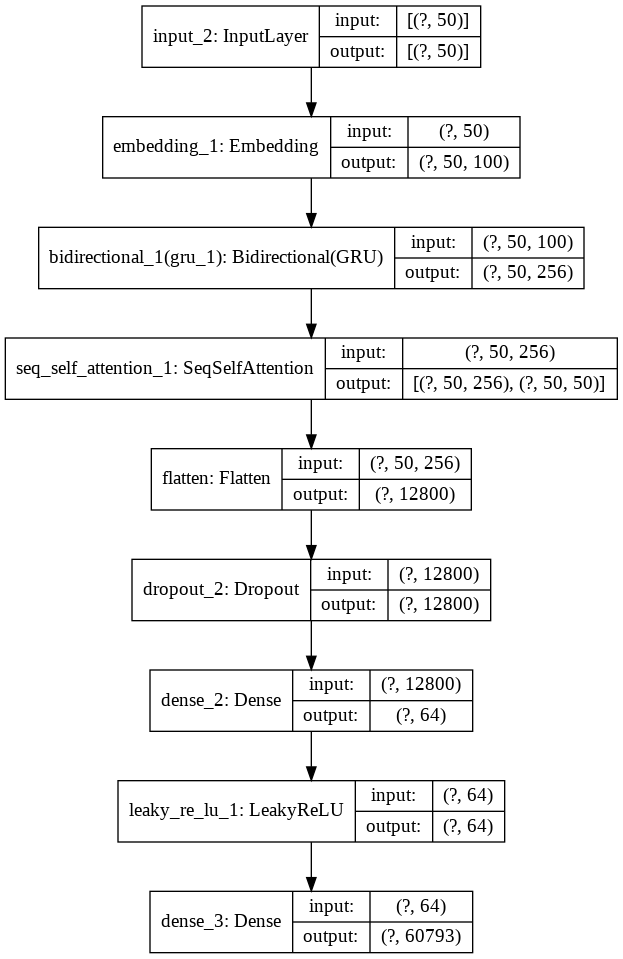

In [ ]:
tf.keras.utils.plot_model(model, 'this_model.png', show_shapes=True)

# Train

In [ ]:
import os
optimizer = Nadam()

checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 model=model)
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
loss_fn = sparse_categorical_crossentropy


In [ ]:
class TrainModel:
  
  def __init__(self, epochs, note_tokenizer, sampled_200_midi, frame_per_second, 
               batch_nnet_size, batch_song, optimizer, checkpoint, loss_fn,
               checkpoint_prefix, total_songs, model):
    self.epochs = epochs
    self.note_tokenizer = note_tokenizer
    self.sampled_200_midi = sampled_200_midi
    self.frame_per_second = frame_per_second
    self.batch_nnet_size = batch_nnet_size
    self.batch_song = batch_song
    self.optimizer = optimizer
    self.checkpoint = checkpoint
    self.loss_fn = loss_fn
    self.checkpoint_prefix = checkpoint_prefix
    self.total_songs = total_songs
    self.model = model
    
  def train(self):
    for epoch in tqdm_notebook(range(self.epochs),desc='epochs'):
      # for each epochs, we shufle the list of all the datasets
      shuffle(self.sampled_200_midi)
      loss_total = 0
      steps = 0
      steps_nnet = 0

      # We will iterate all songs by self.song_size
      for i in tqdm_notebook(range(0,self.total_songs, self.batch_song), desc='MUSIC'):

        steps += 1
        inputs_nnet_large, outputs_nnet_large = generate_batch_song(
            self.sampled_200_midi, self.batch_song, start_index=i, fs=self.frame_per_second, 
            seq_len=seq_len, use_tqdm=False) # We use the function that have been defined here
        inputs_nnet_large = np.array(self.note_tokenizer.transform(inputs_nnet_large), dtype=np.int32)
        outputs_nnet_large = np.array(self.note_tokenizer.transform(outputs_nnet_large), dtype=np.int32)

        index_shuffled = np.arange(start=0, stop=len(inputs_nnet_large))
        np.random.shuffle(index_shuffled)

        for nnet_steps in tqdm_notebook(range(0,len(index_shuffled),self.batch_nnet_size)):
          steps_nnet += 1
          current_index = index_shuffled[nnet_steps:nnet_steps+self.batch_nnet_size]
          inputs_nnet, outputs_nnet = inputs_nnet_large[current_index], outputs_nnet_large[current_index]
          
          # To make sure no exception thrown by tensorflow on autograph
          if len(inputs_nnet) // self.batch_nnet_size != 1:
            break
          loss = self.train_step(inputs_nnet, outputs_nnet)
          loss_total += tf.math.reduce_sum(loss)
          if steps_nnet % 20 == 0:
            print("epochs {} | Steps {} | total loss : {}".format(epoch + 1, steps_nnet, loss_total))

      checkpoint.save(file_prefix = self.checkpoint_prefix)
  
  @tf.function
  def train_step(self, inputs, targets):
    with tf.GradientTape() as tape:
      prediction = self.model(inputs)
      loss = self.loss_fn(targets, prediction)
    gradients = tape.gradient(loss, self.model.trainable_variables)
    self.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))
    return loss

# Train Here
Beware that the time of one epoch is around 1 hour.

In [ ]:
seq_len = 50
EPOCHS = 4
BATCH_SONG = 16
BATCH_NNET_SIZE = 96
TOTAL_SONGS = len(sampled_200_midi)
FRAME_PER_SECOND = 5

train_class = TrainModel(EPOCHS, note_tokenizer, sampled_200_midi, FRAME_PER_SECOND,
                  BATCH_NNET_SIZE, BATCH_SONG, optimizer, checkpoint, loss_fn,
                  checkpoint_prefix, TOTAL_SONGS, model)

train_class.train()

epochs:   0%|          | 0/4 [00:00<?, ?it/s]

MUSIC:   0%|          | 0/7 [00:00<?, ?it/s]

Instrument(program=0, is_drum=False, name="")
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]] (128, 4021)
Instrument(program=0, is_drum=False, name="")
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]] (128, 1563)
Instrument(program=0, is_drum=False, name="")
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]] (128, 2287)
Instrument(program=0, is_drum=False, name="")
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]] (128, 2919)
Instrument(program=0, is_drum=False, name="")
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 

  0%|          | 0/412 [00:00<?, ?it/s]

epochs 1 | Steps 20 | total loss : 19977.841796875
epochs 1 | Steps 40 | total loss : 38462.03515625
epochs 1 | Steps 60 | total loss : 56692.13671875
epochs 1 | Steps 80 | total loss : 74824.90625
epochs 1 | Steps 100 | total loss : 92685.9609375
epochs 1 | Steps 120 | total loss : 110209.578125
epochs 1 | Steps 140 | total loss : 127797.9921875
epochs 1 | Steps 160 | total loss : 145389.84375
epochs 1 | Steps 180 | total loss : 162787.421875
epochs 1 | Steps 200 | total loss : 180258.03125
epochs 1 | Steps 220 | total loss : 197744.390625
epochs 1 | Steps 240 | total loss : 214904.359375
epochs 1 | Steps 260 | total loss : 232114.078125
epochs 1 | Steps 280 | total loss : 249292.546875
epochs 1 | Steps 300 | total loss : 266336.3125
epochs 1 | Steps 320 | total loss : 283059.125
epochs 1 | Steps 340 | total loss : 299895.21875
epochs 1 | Steps 360 | total loss : 316671.8125
epochs 1 | Steps 380 | total loss : 333734.21875
epochs 1 | Steps 400 | total loss : 350303.875
Instrument(prog

  0%|          | 0/455 [00:00<?, ?it/s]

epochs 1 | Steps 420 | total loss : 367894.0
epochs 1 | Steps 440 | total loss : 385962.28125
epochs 1 | Steps 460 | total loss : 403712.25
epochs 1 | Steps 480 | total loss : 420946.375
epochs 1 | Steps 500 | total loss : 438295.6875
epochs 1 | Steps 520 | total loss : 455207.0625
epochs 1 | Steps 540 | total loss : 471999.6875
epochs 1 | Steps 560 | total loss : 488379.5
epochs 1 | Steps 580 | total loss : 504726.78125
epochs 1 | Steps 600 | total loss : 520976.75
epochs 1 | Steps 620 | total loss : 537195.8125
epochs 1 | Steps 640 | total loss : 553339.6875
epochs 1 | Steps 660 | total loss : 568870.5625
epochs 1 | Steps 680 | total loss : 584402.6875
epochs 1 | Steps 700 | total loss : 600199.3125
epochs 1 | Steps 720 | total loss : 615721.4375
epochs 1 | Steps 740 | total loss : 631136.125
epochs 1 | Steps 760 | total loss : 646143.25
epochs 1 | Steps 780 | total loss : 661294.0
epochs 1 | Steps 800 | total loss : 676107.5625
epochs 1 | Steps 820 | total loss : 691211.0625
epochs 

  0%|          | 0/364 [00:00<?, ?it/s]

epochs 1 | Steps 880 | total loss : 737469.5
epochs 1 | Steps 900 | total loss : 756263.0
epochs 1 | Steps 920 | total loss : 774195.8125
epochs 1 | Steps 940 | total loss : 791780.4375
epochs 1 | Steps 960 | total loss : 809334.25
epochs 1 | Steps 980 | total loss : 826375.1875
epochs 1 | Steps 1000 | total loss : 843323.0
epochs 1 | Steps 1020 | total loss : 859701.875
epochs 1 | Steps 1040 | total loss : 875687.625
epochs 1 | Steps 1060 | total loss : 891491.3125
epochs 1 | Steps 1080 | total loss : 906868.125
epochs 1 | Steps 1100 | total loss : 922426.25
epochs 1 | Steps 1120 | total loss : 937168.75
epochs 1 | Steps 1140 | total loss : 951971.4375
epochs 1 | Steps 1160 | total loss : 966476.0625
epochs 1 | Steps 1180 | total loss : 980839.4375
epochs 1 | Steps 1200 | total loss : 995225.5
epochs 1 | Steps 1220 | total loss : 1009153.875
Instrument(program=0, is_drum=False, name="")
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0

  0%|          | 0/346 [00:00<?, ?it/s]

epochs 1 | Steps 1240 | total loss : 1024039.75
epochs 1 | Steps 1260 | total loss : 1041377.375
epochs 1 | Steps 1280 | total loss : 1058297.375
epochs 1 | Steps 1300 | total loss : 1074657.25
epochs 1 | Steps 1320 | total loss : 1090630.5
epochs 1 | Steps 1340 | total loss : 1106627.125
epochs 1 | Steps 1360 | total loss : 1122318.0
epochs 1 | Steps 1380 | total loss : 1137819.875
epochs 1 | Steps 1400 | total loss : 1152765.125
epochs 1 | Steps 1420 | total loss : 1167512.25
epochs 1 | Steps 1440 | total loss : 1182149.375
epochs 1 | Steps 1460 | total loss : 1196716.375
epochs 1 | Steps 1480 | total loss : 1211289.875
epochs 1 | Steps 1500 | total loss : 1225471.375
epochs 1 | Steps 1520 | total loss : 1239641.625
epochs 1 | Steps 1540 | total loss : 1253476.0
epochs 1 | Steps 1560 | total loss : 1267203.75
Instrument(program=0, is_drum=False, name="")
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 

  0%|          | 0/322 [00:00<?, ?it/s]

epochs 1 | Steps 1580 | total loss : 1280423.375
epochs 1 | Steps 1600 | total loss : 1297950.0
epochs 1 | Steps 1620 | total loss : 1314995.375
epochs 1 | Steps 1640 | total loss : 1331498.375
epochs 1 | Steps 1660 | total loss : 1347661.5
epochs 1 | Steps 1680 | total loss : 1363593.625
epochs 1 | Steps 1700 | total loss : 1378973.875
epochs 1 | Steps 1720 | total loss : 1393934.25
epochs 1 | Steps 1740 | total loss : 1408812.5
epochs 1 | Steps 1760 | total loss : 1423322.875
epochs 1 | Steps 1780 | total loss : 1437781.5
epochs 1 | Steps 1800 | total loss : 1451750.0
epochs 1 | Steps 1820 | total loss : 1465757.75
epochs 1 | Steps 1840 | total loss : 1479555.875
epochs 1 | Steps 1860 | total loss : 1493054.0
epochs 1 | Steps 1880 | total loss : 1506639.625
Instrument(program=0, is_drum=False, name="")
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]] (128, 1546)
Instrument(progr

  0%|          | 0/429 [00:00<?, ?it/s]

epochs 1 | Steps 1900 | total loss : 1519346.0
epochs 1 | Steps 1920 | total loss : 1537503.125
epochs 1 | Steps 1940 | total loss : 1555423.125
epochs 1 | Steps 1960 | total loss : 1572297.0
epochs 1 | Steps 1980 | total loss : 1589203.125
epochs 1 | Steps 2000 | total loss : 1605488.875
epochs 1 | Steps 2020 | total loss : 1621846.875
epochs 1 | Steps 2040 | total loss : 1637661.75
epochs 1 | Steps 2060 | total loss : 1653107.125
epochs 1 | Steps 2080 | total loss : 1668594.875
epochs 1 | Steps 2100 | total loss : 1683374.125
epochs 1 | Steps 2120 | total loss : 1697726.375
epochs 1 | Steps 2140 | total loss : 1712071.25
epochs 1 | Steps 2160 | total loss : 1726190.875
epochs 1 | Steps 2180 | total loss : 1740114.0
epochs 1 | Steps 2200 | total loss : 1753495.125
epochs 1 | Steps 2220 | total loss : 1767185.25
epochs 1 | Steps 2240 | total loss : 1780754.5
epochs 1 | Steps 2260 | total loss : 1794044.375
epochs 1 | Steps 2280 | total loss : 1807182.0
epochs 1 | Steps 2300 | total los

  0%|          | 0/171 [00:00<?, ?it/s]

epochs 1 | Steps 2340 | total loss : 1848203.25
epochs 1 | Steps 2360 | total loss : 1864618.25
epochs 1 | Steps 2380 | total loss : 1879784.625
epochs 1 | Steps 2400 | total loss : 1895014.5
epochs 1 | Steps 2420 | total loss : 1909560.125
epochs 1 | Steps 2440 | total loss : 1923530.0
epochs 1 | Steps 2460 | total loss : 1937012.625
epochs 1 | Steps 2480 | total loss : 1950340.25


MUSIC:   0%|          | 0/7 [00:00<?, ?it/s]

Instrument(program=0, is_drum=False, name="")
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]] (128, 2815)
Instrument(program=0, is_drum=False, name="")
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]] (128, 6824)
Instrument(program=0, is_drum=False, name="")
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]] (128, 225)
Instrument(program=0, is_drum=False, name="")
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]] (128, 1426)
Instrument(program=0, is_drum=False, name="")
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0

  0%|          | 0/336 [00:00<?, ?it/s]

epochs 2 | Steps 20 | total loss : 13992.076171875
epochs 2 | Steps 40 | total loss : 26825.873046875
epochs 2 | Steps 60 | total loss : 39510.953125
epochs 2 | Steps 80 | total loss : 52137.65625
epochs 2 | Steps 100 | total loss : 64397.49609375
epochs 2 | Steps 120 | total loss : 76406.7890625
epochs 2 | Steps 140 | total loss : 88312.6015625
epochs 2 | Steps 160 | total loss : 100069.28125
epochs 2 | Steps 180 | total loss : 111863.859375
epochs 2 | Steps 200 | total loss : 123409.40625
epochs 2 | Steps 220 | total loss : 134933.5625
epochs 2 | Steps 240 | total loss : 146272.828125
epochs 2 | Steps 260 | total loss : 157598.5
epochs 2 | Steps 280 | total loss : 168696.859375
epochs 2 | Steps 300 | total loss : 179777.84375
epochs 2 | Steps 320 | total loss : 191013.140625
Instrument(program=0, is_drum=False, name="")
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]] (128, 3575

  0%|          | 0/444 [00:00<?, ?it/s]

epochs 2 | Steps 340 | total loss : 202116.21875
epochs 2 | Steps 360 | total loss : 215273.859375
epochs 2 | Steps 380 | total loss : 228211.8125
epochs 2 | Steps 400 | total loss : 240844.375
epochs 2 | Steps 420 | total loss : 253640.546875
epochs 2 | Steps 440 | total loss : 265960.09375
epochs 2 | Steps 460 | total loss : 277884.21875
epochs 2 | Steps 480 | total loss : 289898.28125
epochs 2 | Steps 500 | total loss : 301610.09375
epochs 2 | Steps 520 | total loss : 313325.5625
epochs 2 | Steps 540 | total loss : 324975.5
epochs 2 | Steps 560 | total loss : 336641.25
epochs 2 | Steps 580 | total loss : 348247.375
epochs 2 | Steps 600 | total loss : 359819.34375
epochs 2 | Steps 620 | total loss : 371104.4375
epochs 2 | Steps 640 | total loss : 382125.53125
epochs 2 | Steps 660 | total loss : 393182.15625
epochs 2 | Steps 680 | total loss : 404243.8125
epochs 2 | Steps 700 | total loss : 415174.90625
epochs 2 | Steps 720 | total loss : 426296.75
epochs 2 | Steps 740 | total loss : 

  0%|          | 0/347 [00:00<?, ?it/s]

epochs 2 | Steps 800 | total loss : 472061.03125
epochs 2 | Steps 820 | total loss : 485939.875
epochs 2 | Steps 840 | total loss : 499638.75
epochs 2 | Steps 860 | total loss : 512794.40625
epochs 2 | Steps 880 | total loss : 525774.125
epochs 2 | Steps 900 | total loss : 538142.75
epochs 2 | Steps 920 | total loss : 550464.0
epochs 2 | Steps 940 | total loss : 563124.4375
epochs 2 | Steps 960 | total loss : 575396.375
epochs 2 | Steps 980 | total loss : 587393.1875
epochs 2 | Steps 1000 | total loss : 599183.0
epochs 2 | Steps 1020 | total loss : 610957.9375
epochs 2 | Steps 1040 | total loss : 622796.4375
epochs 2 | Steps 1060 | total loss : 634419.75
epochs 2 | Steps 1080 | total loss : 645936.5625
epochs 2 | Steps 1100 | total loss : 656998.25
epochs 2 | Steps 1120 | total loss : 668275.5
Instrument(program=0, is_drum=False, name="")
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0

  0%|          | 0/402 [00:00<?, ?it/s]

epochs 2 | Steps 1140 | total loss : 680942.875
epochs 2 | Steps 1160 | total loss : 694935.0
epochs 2 | Steps 1180 | total loss : 708032.5625
epochs 2 | Steps 1200 | total loss : 721087.5625
epochs 2 | Steps 1220 | total loss : 733686.375
epochs 2 | Steps 1240 | total loss : 746418.9375
epochs 2 | Steps 1260 | total loss : 758966.0625
epochs 2 | Steps 1280 | total loss : 771169.6875
epochs 2 | Steps 1300 | total loss : 783397.4375
epochs 2 | Steps 1320 | total loss : 795658.375
epochs 2 | Steps 1340 | total loss : 807573.5625
epochs 2 | Steps 1360 | total loss : 819197.4375
epochs 2 | Steps 1380 | total loss : 830733.0625
epochs 2 | Steps 1400 | total loss : 842302.9375
epochs 2 | Steps 1420 | total loss : 854046.875
epochs 2 | Steps 1440 | total loss : 865264.6875
epochs 2 | Steps 1460 | total loss : 876733.5
epochs 2 | Steps 1480 | total loss : 887935.5
epochs 2 | Steps 1500 | total loss : 899006.875
epochs 2 | Steps 1520 | total loss : 910038.0625
Instrument(program=0, is_drum=Fals

  0%|          | 0/478 [00:00<?, ?it/s]

epochs 2 | Steps 1540 | total loss : 921988.625
epochs 2 | Steps 1560 | total loss : 935031.9375
epochs 2 | Steps 1580 | total loss : 947481.1875
epochs 2 | Steps 1600 | total loss : 959982.5625
epochs 2 | Steps 1620 | total loss : 972059.25
epochs 2 | Steps 1640 | total loss : 984003.8125
epochs 2 | Steps 1660 | total loss : 995549.5625
epochs 2 | Steps 1680 | total loss : 1007388.75
epochs 2 | Steps 1700 | total loss : 1018646.375
epochs 2 | Steps 1720 | total loss : 1029900.75
epochs 2 | Steps 1740 | total loss : 1041251.625
epochs 2 | Steps 1760 | total loss : 1052117.625
epochs 2 | Steps 1780 | total loss : 1063280.75
epochs 2 | Steps 1800 | total loss : 1073986.0
epochs 2 | Steps 1820 | total loss : 1084799.375
epochs 2 | Steps 1840 | total loss : 1095413.75
epochs 2 | Steps 1860 | total loss : 1105964.75
epochs 2 | Steps 1880 | total loss : 1116354.75
epochs 2 | Steps 1900 | total loss : 1126891.375
epochs 2 | Steps 1920 | total loss : 1137099.75
epochs 2 | Steps 1940 | total lo

  0%|          | 0/421 [00:00<?, ?it/s]

epochs 2 | Steps 2020 | total loss : 1189860.0
epochs 2 | Steps 2040 | total loss : 1203274.0
epochs 2 | Steps 2060 | total loss : 1215686.5
epochs 2 | Steps 2080 | total loss : 1227966.5
epochs 2 | Steps 2100 | total loss : 1240112.0
epochs 2 | Steps 2120 | total loss : 1251788.25
epochs 2 | Steps 2140 | total loss : 1263562.25
epochs 2 | Steps 2160 | total loss : 1274809.25
epochs 2 | Steps 2180 | total loss : 1286002.875
epochs 2 | Steps 2200 | total loss : 1297181.375
epochs 2 | Steps 2220 | total loss : 1308309.875
epochs 2 | Steps 2240 | total loss : 1319496.75
epochs 2 | Steps 2260 | total loss : 1330451.625
epochs 2 | Steps 2280 | total loss : 1341321.0
epochs 2 | Steps 2300 | total loss : 1351791.75
epochs 2 | Steps 2320 | total loss : 1362411.25
epochs 2 | Steps 2340 | total loss : 1372997.375
epochs 2 | Steps 2360 | total loss : 1383231.375
epochs 2 | Steps 2380 | total loss : 1393529.875
epochs 2 | Steps 2400 | total loss : 1403413.5
epochs 2 | Steps 2420 | total loss : 141

  0%|          | 0/70 [00:00<?, ?it/s]

epochs 2 | Steps 2440 | total loss : 1424495.5
epochs 2 | Steps 2460 | total loss : 1435984.625
epochs 2 | Steps 2480 | total loss : 1446584.625


MUSIC:   0%|          | 0/7 [00:00<?, ?it/s]

Instrument(program=0, is_drum=False, name="")
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]] (128, 636)
Instrument(program=0, is_drum=False, name="")
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]] (128, 1328)
Instrument(program=0, is_drum=False, name="")
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]] (128, 1929)
Instrument(program=0, is_drum=False, name="")
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]] (128, 2017)
Instrument(program=0, is_drum=False, name="")
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0

  0%|          | 0/396 [00:00<?, ?it/s]

epochs 3 | Steps 20 | total loss : 8918.2509765625
epochs 3 | Steps 40 | total loss : 17352.279296875
epochs 3 | Steps 60 | total loss : 25583.623046875
epochs 3 | Steps 80 | total loss : 34218.30859375
epochs 3 | Steps 100 | total loss : 42607.63671875
epochs 3 | Steps 120 | total loss : 50856.484375
epochs 3 | Steps 140 | total loss : 59115.72265625
epochs 3 | Steps 160 | total loss : 67525.6875
epochs 3 | Steps 180 | total loss : 75801.734375
epochs 3 | Steps 200 | total loss : 83689.578125
epochs 3 | Steps 220 | total loss : 91883.15625
epochs 3 | Steps 240 | total loss : 100031.8125
epochs 3 | Steps 260 | total loss : 108328.6953125
epochs 3 | Steps 280 | total loss : 116205.71875
epochs 3 | Steps 300 | total loss : 124181.0859375
epochs 3 | Steps 320 | total loss : 132283.578125
epochs 3 | Steps 340 | total loss : 140109.25
epochs 3 | Steps 360 | total loss : 148058.84375
epochs 3 | Steps 380 | total loss : 155839.3125
Instrument(program=0, is_drum=False, name="")
[[0. 0. 0. ... 

  0%|          | 0/428 [00:00<?, ?it/s]

epochs 3 | Steps 400 | total loss : 163698.234375
epochs 3 | Steps 420 | total loss : 172242.703125
epochs 3 | Steps 440 | total loss : 180572.90625
epochs 3 | Steps 460 | total loss : 189267.046875
epochs 3 | Steps 480 | total loss : 197542.484375
epochs 3 | Steps 500 | total loss : 205850.390625
epochs 3 | Steps 520 | total loss : 214291.25
epochs 3 | Steps 540 | total loss : 222743.03125
epochs 3 | Steps 560 | total loss : 231037.546875
epochs 3 | Steps 580 | total loss : 239224.0625
epochs 3 | Steps 600 | total loss : 247384.84375
epochs 3 | Steps 620 | total loss : 255358.203125
epochs 3 | Steps 640 | total loss : 263648.03125
epochs 3 | Steps 660 | total loss : 271553.65625
epochs 3 | Steps 680 | total loss : 279677.96875
epochs 3 | Steps 700 | total loss : 287553.375
epochs 3 | Steps 720 | total loss : 295602.84375
epochs 3 | Steps 740 | total loss : 303758.15625
epochs 3 | Steps 760 | total loss : 311841.75
epochs 3 | Steps 780 | total loss : 319760.03125
epochs 3 | Steps 800 |

  0%|          | 0/292 [00:00<?, ?it/s]

epochs 3 | Steps 840 | total loss : 344352.875
epochs 3 | Steps 860 | total loss : 353646.78125
epochs 3 | Steps 880 | total loss : 363050.40625
epochs 3 | Steps 900 | total loss : 371943.1875
epochs 3 | Steps 920 | total loss : 380863.03125
epochs 3 | Steps 940 | total loss : 390004.34375
epochs 3 | Steps 960 | total loss : 398886.40625
epochs 3 | Steps 980 | total loss : 407665.15625
epochs 3 | Steps 1000 | total loss : 416279.8125
epochs 3 | Steps 1020 | total loss : 425146.1875
epochs 3 | Steps 1040 | total loss : 433818.71875
epochs 3 | Steps 1060 | total loss : 442144.0
epochs 3 | Steps 1080 | total loss : 450828.25
epochs 3 | Steps 1100 | total loss : 459614.375
Instrument(program=0, is_drum=False, name="")
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]] (128, 3692)
Instrument(program=0, is_drum=False, name="")
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. .

  0%|          | 0/467 [00:00<?, ?it/s]

epochs 3 | Steps 1120 | total loss : 467801.03125
epochs 3 | Steps 1140 | total loss : 477936.78125
epochs 3 | Steps 1160 | total loss : 488047.40625
epochs 3 | Steps 1180 | total loss : 497954.5
epochs 3 | Steps 1200 | total loss : 507853.1875
epochs 3 | Steps 1220 | total loss : 517462.625
epochs 3 | Steps 1240 | total loss : 527158.9375
epochs 3 | Steps 1260 | total loss : 536614.3125
epochs 3 | Steps 1280 | total loss : 546236.5
epochs 3 | Steps 1300 | total loss : 555828.875
epochs 3 | Steps 1320 | total loss : 565319.875
epochs 3 | Steps 1340 | total loss : 574960.3125
epochs 3 | Steps 1360 | total loss : 584302.1875
epochs 3 | Steps 1380 | total loss : 593553.3125
epochs 3 | Steps 1400 | total loss : 602935.5625
epochs 3 | Steps 1420 | total loss : 611994.625
epochs 3 | Steps 1440 | total loss : 621236.0625
epochs 3 | Steps 1460 | total loss : 630371.1875
epochs 3 | Steps 1480 | total loss : 638961.0625
epochs 3 | Steps 1500 | total loss : 648307.0625
epochs 3 | Steps 1520 | tot

  0%|          | 0/313 [00:00<?, ?it/s]

epochs 3 | Steps 1600 | total loss : 693863.625
epochs 3 | Steps 1620 | total loss : 703795.625
epochs 3 | Steps 1640 | total loss : 713945.0
epochs 3 | Steps 1660 | total loss : 723764.9375
epochs 3 | Steps 1680 | total loss : 733581.375
epochs 3 | Steps 1700 | total loss : 743082.3125
epochs 3 | Steps 1720 | total loss : 752805.4375
epochs 3 | Steps 1740 | total loss : 762320.75
epochs 3 | Steps 1760 | total loss : 771599.4375
epochs 3 | Steps 1780 | total loss : 780794.5625
epochs 3 | Steps 1800 | total loss : 790129.875
epochs 3 | Steps 1820 | total loss : 799484.1875
epochs 3 | Steps 1840 | total loss : 808477.875
epochs 3 | Steps 1860 | total loss : 817686.6875
epochs 3 | Steps 1880 | total loss : 826645.5
Instrument(program=0, is_drum=False, name="")
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]] (128, 1108)
Instrument(program=0, is_drum=False, name="")
[[0. 0. 0. ... 0. 

  0%|          | 0/503 [00:00<?, ?it/s]

epochs 3 | Steps 1900 | total loss : 835196.375
epochs 3 | Steps 1920 | total loss : 844676.5625
epochs 3 | Steps 1940 | total loss : 853993.0
epochs 3 | Steps 1960 | total loss : 863216.375
epochs 3 | Steps 1980 | total loss : 872163.3125
epochs 3 | Steps 2000 | total loss : 880864.8125
epochs 3 | Steps 2020 | total loss : 889641.4375
epochs 3 | Steps 2040 | total loss : 898480.0
epochs 3 | Steps 2060 | total loss : 906981.6875
epochs 3 | Steps 2080 | total loss : 915503.4375
epochs 3 | Steps 2100 | total loss : 923844.875
epochs 3 | Steps 2120 | total loss : 932171.9375
epochs 3 | Steps 2140 | total loss : 940620.625
epochs 3 | Steps 2160 | total loss : 948889.75
epochs 3 | Steps 2180 | total loss : 957030.8125
epochs 3 | Steps 2200 | total loss : 965427.875
epochs 3 | Steps 2220 | total loss : 973745.5625
epochs 3 | Steps 2240 | total loss : 981822.5625
epochs 3 | Steps 2260 | total loss : 989841.75
epochs 3 | Steps 2280 | total loss : 998287.3125
epochs 3 | Steps 2300 | total loss 

  0%|          | 0/101 [00:00<?, ?it/s]

epochs 3 | Steps 2400 | total loss : 1045753.3125
epochs 3 | Steps 2420 | total loss : 1055083.25
epochs 3 | Steps 2440 | total loss : 1064290.125
epochs 3 | Steps 2460 | total loss : 1073444.125
epochs 3 | Steps 2480 | total loss : 1082372.375


MUSIC:   0%|          | 0/7 [00:00<?, ?it/s]

Instrument(program=0, is_drum=False, name="")
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]] (128, 1410)
Instrument(program=0, is_drum=False, name="")
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]] (128, 1375)
Instrument(program=0, is_drum=False, name="")
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]] (128, 2265)
Instrument(program=0, is_drum=False, name="")
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]] (128, 2910)
Instrument(program=0, is_drum=False, name="")
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 

  0%|          | 0/422 [00:00<?, ?it/s]

epochs 4 | Steps 20 | total loss : 6496.40673828125
epochs 4 | Steps 40 | total loss : 13427.791015625
epochs 4 | Steps 60 | total loss : 20245.033203125
epochs 4 | Steps 80 | total loss : 27150.08984375
epochs 4 | Steps 100 | total loss : 33972.01953125
epochs 4 | Steps 120 | total loss : 40770.43359375
epochs 4 | Steps 140 | total loss : 47684.54296875
epochs 4 | Steps 160 | total loss : 54560.265625
epochs 4 | Steps 180 | total loss : 61297.23046875
epochs 4 | Steps 200 | total loss : 68040.15625
epochs 4 | Steps 220 | total loss : 74962.96875
epochs 4 | Steps 240 | total loss : 81916.7109375
epochs 4 | Steps 260 | total loss : 88691.84375
epochs 4 | Steps 280 | total loss : 95501.734375
epochs 4 | Steps 300 | total loss : 102333.515625
epochs 4 | Steps 320 | total loss : 109418.828125
epochs 4 | Steps 340 | total loss : 116189.6484375
epochs 4 | Steps 360 | total loss : 123017.7109375
epochs 4 | Steps 380 | total loss : 129672.5390625
epochs 4 | Steps 400 | total loss : 136442.2968

  0%|          | 0/380 [00:00<?, ?it/s]

epochs 4 | Steps 440 | total loss : 149262.609375
epochs 4 | Steps 460 | total loss : 155783.234375
epochs 4 | Steps 480 | total loss : 162488.921875
epochs 4 | Steps 500 | total loss : 169413.5625
epochs 4 | Steps 520 | total loss : 176223.703125
epochs 4 | Steps 540 | total loss : 183116.484375
epochs 4 | Steps 560 | total loss : 190095.625
epochs 4 | Steps 580 | total loss : 197154.703125
epochs 4 | Steps 600 | total loss : 204301.25
epochs 4 | Steps 620 | total loss : 211205.984375
epochs 4 | Steps 640 | total loss : 218213.78125
epochs 4 | Steps 660 | total loss : 225118.046875
epochs 4 | Steps 680 | total loss : 231793.65625
epochs 4 | Steps 700 | total loss : 238927.28125
epochs 4 | Steps 720 | total loss : 245782.25
epochs 4 | Steps 740 | total loss : 252584.734375
epochs 4 | Steps 760 | total loss : 259472.21875
epochs 4 | Steps 780 | total loss : 266414.78125
epochs 4 | Steps 800 | total loss : 273230.25
Instrument(program=0, is_drum=False, name="")
[[0. 0. 0. ... 0. 0. 0.]
 

  0%|          | 0/444 [00:00<?, ?it/s]

epochs 4 | Steps 820 | total loss : 278774.34375
epochs 4 | Steps 840 | total loss : 285007.625
epochs 4 | Steps 860 | total loss : 291462.75
epochs 4 | Steps 880 | total loss : 297930.84375
epochs 4 | Steps 900 | total loss : 304413.0
epochs 4 | Steps 920 | total loss : 311141.78125
epochs 4 | Steps 940 | total loss : 317747.40625
epochs 4 | Steps 960 | total loss : 324349.84375
epochs 4 | Steps 980 | total loss : 331065.8125
epochs 4 | Steps 1000 | total loss : 337653.875
epochs 4 | Steps 1020 | total loss : 344411.96875
epochs 4 | Steps 1040 | total loss : 350960.4375
epochs 4 | Steps 1060 | total loss : 357408.9375
epochs 4 | Steps 1080 | total loss : 363855.40625
epochs 4 | Steps 1100 | total loss : 370350.4375
epochs 4 | Steps 1120 | total loss : 376613.25
epochs 4 | Steps 1140 | total loss : 382920.25
epochs 4 | Steps 1160 | total loss : 389366.5
epochs 4 | Steps 1180 | total loss : 395606.375
epochs 4 | Steps 1200 | total loss : 401706.15625
epochs 4 | Steps 1220 | total loss :

  0%|          | 0/389 [00:00<?, ?it/s]

epochs 4 | Steps 1260 | total loss : 420312.28125
epochs 4 | Steps 1280 | total loss : 427217.71875
epochs 4 | Steps 1300 | total loss : 434317.9375
epochs 4 | Steps 1320 | total loss : 441501.6875
epochs 4 | Steps 1340 | total loss : 448440.75
epochs 4 | Steps 1360 | total loss : 455553.125
epochs 4 | Steps 1380 | total loss : 462632.125
epochs 4 | Steps 1400 | total loss : 469769.28125
epochs 4 | Steps 1420 | total loss : 476864.59375
epochs 4 | Steps 1440 | total loss : 483830.34375
epochs 4 | Steps 1460 | total loss : 490769.65625
epochs 4 | Steps 1480 | total loss : 497483.0625
epochs 4 | Steps 1500 | total loss : 504195.46875
epochs 4 | Steps 1520 | total loss : 510893.0
epochs 4 | Steps 1540 | total loss : 517754.125
epochs 4 | Steps 1560 | total loss : 524495.4375
epochs 4 | Steps 1580 | total loss : 531251.875
epochs 4 | Steps 1600 | total loss : 537898.9375
epochs 4 | Steps 1620 | total loss : 544569.5625
Instrument(program=0, is_drum=False, name="")
[[0. 0. 0. ... 0. 0. 0.]


  0%|          | 0/399 [00:00<?, ?it/s]

epochs 4 | Steps 1640 | total loss : 550997.1875
epochs 4 | Steps 1660 | total loss : 558318.875
epochs 4 | Steps 1680 | total loss : 565801.5
epochs 4 | Steps 1700 | total loss : 573398.5625
epochs 4 | Steps 1720 | total loss : 580899.25
epochs 4 | Steps 1740 | total loss : 588433.1875
epochs 4 | Steps 1760 | total loss : 595933.0625
epochs 4 | Steps 1780 | total loss : 603341.1875
epochs 4 | Steps 1800 | total loss : 611000.9375
epochs 4 | Steps 1820 | total loss : 618499.5625
epochs 4 | Steps 1840 | total loss : 625799.4375
epochs 4 | Steps 1860 | total loss : 633142.875
epochs 4 | Steps 1880 | total loss : 640605.8125
epochs 4 | Steps 1900 | total loss : 648001.625
epochs 4 | Steps 1920 | total loss : 655445.0
epochs 4 | Steps 1940 | total loss : 662858.5625
epochs 4 | Steps 1960 | total loss : 670254.5625
epochs 4 | Steps 1980 | total loss : 677780.125
epochs 4 | Steps 2000 | total loss : 685055.4375
epochs 4 | Steps 2020 | total loss : 692421.4375
Instrument(program=0, is_drum=Fa

  0%|          | 0/395 [00:00<?, ?it/s]

epochs 4 | Steps 2040 | total loss : 699419.875
epochs 4 | Steps 2060 | total loss : 706754.8125
epochs 4 | Steps 2080 | total loss : 713866.375
epochs 4 | Steps 2100 | total loss : 721050.5
epochs 4 | Steps 2120 | total loss : 728444.0
epochs 4 | Steps 2140 | total loss : 735777.3125
epochs 4 | Steps 2160 | total loss : 742981.6875
epochs 4 | Steps 2180 | total loss : 750169.75
epochs 4 | Steps 2200 | total loss : 757466.375
epochs 4 | Steps 2220 | total loss : 764588.75
epochs 4 | Steps 2240 | total loss : 771888.3125
epochs 4 | Steps 2260 | total loss : 779112.75
epochs 4 | Steps 2280 | total loss : 786064.6875
epochs 4 | Steps 2300 | total loss : 793404.625
epochs 4 | Steps 2320 | total loss : 800519.375
epochs 4 | Steps 2340 | total loss : 807640.25
epochs 4 | Steps 2360 | total loss : 814716.625
epochs 4 | Steps 2380 | total loss : 821558.0625
epochs 4 | Steps 2400 | total loss : 828483.4375
epochs 4 | Steps 2420 | total loss : 835522.75
Instrument(program=0, is_drum=False, name=

  0%|          | 0/71 [00:00<?, ?it/s]

epochs 4 | Steps 2440 | total loss : 842469.0
epochs 4 | Steps 2460 | total loss : 849969.9375
epochs 4 | Steps 2480 | total loss : 857657.125


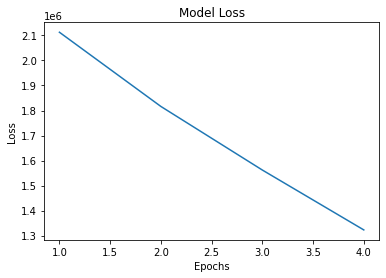

In [ ]:
# importing the required module
import matplotlib.pyplot as plt
 
# x axis values
x = [1,2,3,4]
# corresponding y axis values
y = [2112877.75,1816263.0,1562080.375,1322672.125]
 
# plotting the points
plt.plot(x, y)
 
# naming the x axis
plt.xlabel('Epochs')
# naming the y axis
plt.ylabel('Loss')
 
# giving a title to my graph
plt.title('Model Loss')
 
# function to show the plot
plt.show()

# Save the model as h5 and The Tokenizer

In [ ]:
os.chdir('/content/drive/Shareddrives/295/Code/RNN_Transformer/pickles')
model.save(MODEL_FILE)
pickle.dump( note_tokenizer, open( TOKENIZER_FILE, "wb" ) )